In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_monthly_energy_cost_filled_days(file_path, time_col='timestamp', power_col='peak_value', freq='5T'):
    # Load and parse data
    df = pd.read_csv(file_path)
    df[time_col] = pd.to_datetime(df[time_col])
    df.set_index(time_col, inplace=True)
    df.sort_index(inplace=True)

    # Tariff (R/kWh)
    block1_limit = 350
    block2_limit = 500
    price_block1 = 2.097255
    price_block2 = 2.405685
    price_block3 = 2.741255

    # Determine full day range
    start_date = df.index.min().floor('D')
    end_date = df.index.max().ceil('D')

    # Containers
    dates = []
    daily_energy_kwh = []
    daily_costs = []

    print("Daily Energy and Cost (filled to full days):\n")

    for day in pd.date_range(start=start_date, end=end_date - pd.Timedelta(days=1), freq='D'):
        day_start = day
        day_end = day + pd.Timedelta(days=1)

        # Time index with expected intervals (default: every 5 minutes)
        full_index = pd.date_range(start=day_start, end=day_end, freq=freq, inclusive='left')

        
        # Extract actual data for the day
        day_data = df.loc[(df.index >= day_start) & (df.index < day_end)]

        # Reindex to fill missing times with 0
        filled = day_data.reindex(full_index, fill_value=0)
        
        # Time axis in hours from 0 to 24
        time_hours = (filled.index - filled.index[0]).total_seconds() / 3600.0

        # Integration (kW × h = kWh)
        energy_kwh = np.trapezoid(filled[power_col].values, time_hours)

        # Tiered tariff
        if energy_kwh <= block1_limit:
            cost = energy_kwh * price_block1
        elif energy_kwh <= block2_limit:
            cost = block1_limit * price_block1 + (energy_kwh - block1_limit) * price_block2
        else:
            cost = block1_limit * price_block1 + \
                   (block2_limit - block1_limit) * price_block2 + \
                   (energy_kwh - block2_limit) * price_block3

        # Store
        dates.append(day)
        daily_energy_kwh.append(energy_kwh)
        daily_costs.append(cost)

        print(f"{day.date()} - Energy: {energy_kwh:.2f} kWh | Cost: R{cost:.2f}")

    # Totals
    total_energy = np.sum(daily_energy_kwh)
    total_cost = np.sum(daily_costs)

    print("\nMonthly Total (filled missing times with 0s):")
    print(f"  Energy: {total_energy:.2f} kWh")
    print(f"  Cost: R{total_cost:.2f}")

    # Plot
    plt.figure(figsize=(14, 6))
    plt.bar(dates, daily_energy_kwh, alpha=0.6, label='Daily Energy (kWh)')
    plt.plot(dates, daily_costs, 'ro-', label='Daily Cost (R)')
    plt.title("Monthly Electricity Usage & Cost (Missing Time Filled with 0 kW)")
    plt.xlabel("Date")
    plt.ylabel("Energy / Cost")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return total_energy, total_cost


Daily Energy and Cost (filled to full days):

2025-04-30 - Energy: 186.57 kWh | Cost: R391.28
2025-05-01 - Energy: 258.57 kWh | Cost: R542.28
2025-05-02 - Energy: 232.62 kWh | Cost: R487.86
2025-05-03 - Energy: 128.58 kWh | Cost: R269.67
2025-05-04 - Energy: 161.29 kWh | Cost: R338.26
2025-05-05 - Energy: 232.66 kWh | Cost: R487.96
2025-05-06 - Energy: 258.91 kWh | Cost: R543.00
2025-05-07 - Energy: 276.65 kWh | Cost: R580.21
2025-05-08 - Energy: 164.06 kWh | Cost: R344.08

Monthly Total (filled missing times with 0s):
  Energy: 1899.91 kWh
  Cost: R3984.60


C:\Users\hp\AppData\Local\Temp\ipykernel_15392\68310555.py:35: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(start=day_start, end=day_end, freq=freq, inclusive='left')


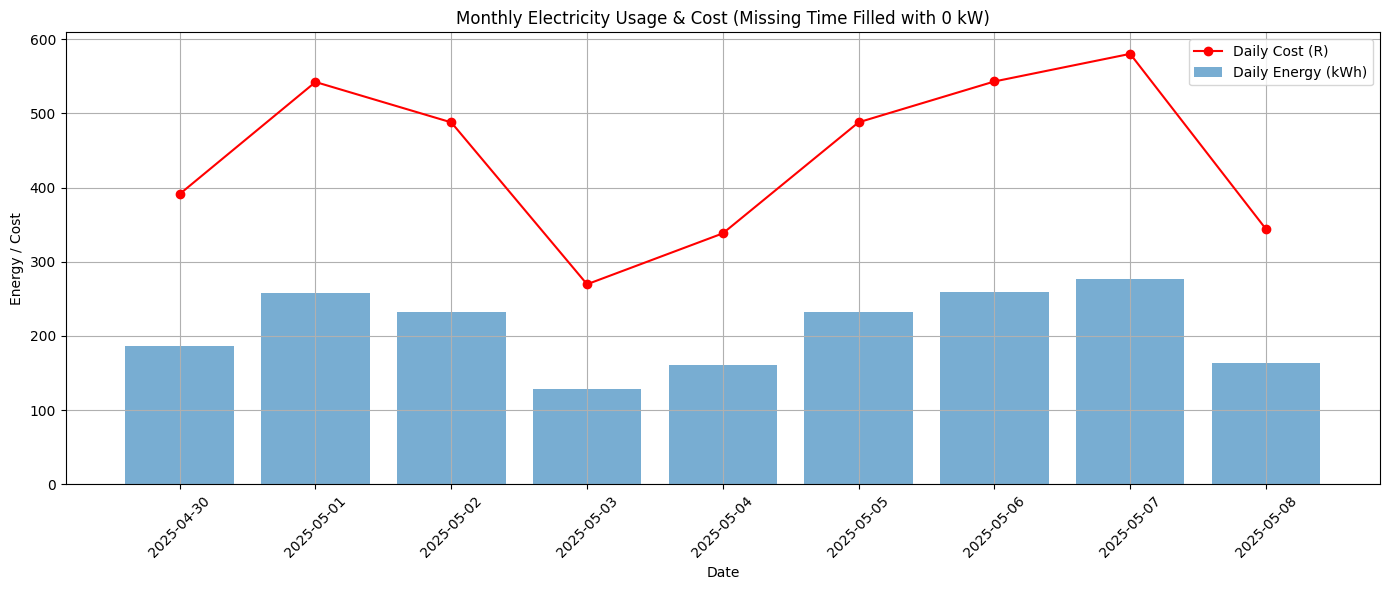

(np.float64(1899.9125250000002), np.float64(3984.601042618875))

In [102]:
file_path = r"C:\Users\hp\Desktop\REG108S\Project\MeasuredDataUpdated.csv"
calculate_monthly_energy_cost_filled_days(file_path, time_col='X-Data', power_col='TOTDemand(kWh/h)Value[kWh/h]', freq='5T')
